# detect pneumonia in chest x-ray images.

# settings

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

print(tf.__version__)

2.6.0


In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/workspace/chest_xray/train/*/*' 
VAL_PATH = ROOT_PATH + '/workspace/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/workspace/chest_xray/test/*/*'

# 실험환경 set-up (초기설정 값, 바꿔가며 실험해보기)
BATCH_SIZE = 16
EPOCHS = 50

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print("train_file 개수:", len(train_filenames))
print("test_file 개수:", len(test_filenames))
print("val_file 개수:", len(val_filenames))

train_file 개수: 5216
test_file 개수: 624
val_file 개수: 16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

# train 내의 정상 이미지 1070개 / 폐렴 이미지 3115개 총 4185개 -> imbalace

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


## dataloader

In [6]:
#tf.data 인스턴스

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
# 파일 구조를 이용하여 파일 경로에 라벨의 힌트를 얻을 수 있다.
# 따라서 해당 경로에 있는 사진을 라벨링 할 수 있다.

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [9]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
#데이터 확인 해보기 

#하나의 데이터에 대해서만 확인
# 180,180,3 크기의 이미지 - True / False 매치
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [12]:
# test dataset에도 적용

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds_nb = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds_nb.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [13]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000, augment_ = True):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    if augment_:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2)
        
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds


#좌우 반전 시킨 ds(ds_ag)와 안한 ds(ds_og)를 구분하여 성능 모니터링에 사용합니다.
train_ds_og = prepare_for_training(train_ds, augment_ = False)
val_ds_og = prepare_for_training(val_ds, augment_ = False)
train_ds_ag = prepare_for_training(train_ds)
val_ds_ag = prepare_for_training(val_ds)


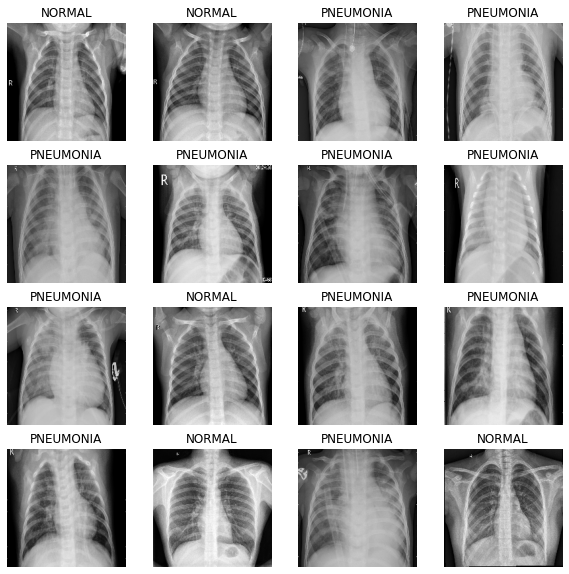

In [14]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds_og))
show_batch(image_batch.numpy(), label_batch.numpy())

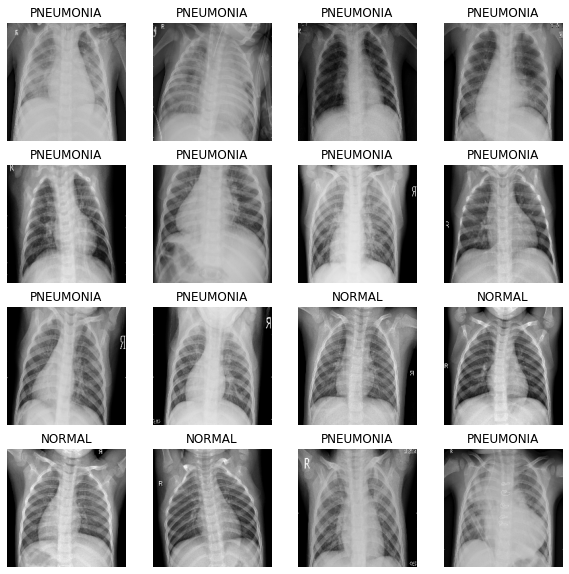

In [15]:
image_batch_ag, label_batch_ag = next(iter(train_ds_ag))
show_batch(image_batch_ag.numpy(), label_batch_ag.numpy())

### 육안으로 확인하였을 때 비슷해보이는 사진이 있고 그 사진이 좌우 반전 된 것을 볼 수 있다. -> augment 잘 적용됨

## 모델링

- dropout 실험을 위해 함수형 API으로 통일하여 사용

In [16]:
#convolution block

def conv_block(layer, filters):
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(layer)
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D()(x)

    return x

In [17]:
#dense block

def dense_block(layer, units, dropout_rate = 0.2, dropout = True):
    x = tf.keras.layers.Dense(units, activation='relu')(layer)
    x = tf.keras.layers.BatchNormalization()(x)
    if dropout:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    return x

In [18]:
def build_model(dropout_= True):
    input_p = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(input_p)
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    
    x = conv_block(x, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    
    if dropout_:
        x = tf.keras.layers.Dropout(0.2)(x)
        
    x = conv_block(x, 256)
    
    if dropout_:
        x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Flatten()(x)

    x = dense_block(x, 512, 0.7)
    x = dense_block(x, 128, 0.5)
    x = dense_block(x, 64, 0.3)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=input_p, outputs=output)
    
    return model

## 데이터 imbalance 처리
- train ds 중 약 1000개가 정상 데이터이고, 약 3000개가 폐렴 데이터였다.

In [19]:
# 1. weigh-balacing : data에서 loss를 계산할 때, 특정 클래스 데이터에 더 큰 loss를 갖도록 가중치를 부여하자!
# 즉, 모델이 더욱 민감하게 반응하게 하는 것.

#0 for normal / 1 for pneumonia
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 90, 90, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 90, 90, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 90, 32)        128   

In [22]:
# batch 16 / epoch 50 / no aug / no dropout

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_og,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_og,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
261/261 [==============================] - 102s 208ms/step - loss: 0.3470 - accuracy: 0.8398 - precision: 0.9628 - recall: 0.8163 - val_loss: 0.6969 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/50
261/261 [==============================] - 52s 201ms/step - loss: 0.2314 - accuracy: 0.9064 - precision: 0.9709 - recall: 0.9013 - val_loss: 1.2347 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/50
261/261 [==============================] - 53s 204ms/step - loss: 0.1975 - accuracy: 0.9241 - precision: 0.9761 - recall: 0.9205 - val_loss: 0.2179 - val_accuracy: 0.8875 - val_precision: 0.8672 - val_recall: 1.0000
Epoch 4/50
261/261 [==============================] - 53s 203ms/step - loss: 0.1702 - accuracy: 0.9373 - precision: 0.9824 - recall: 0.9324 - val_loss: 0.2207 - val_accuracy: 0.9125 - val_precision: 1.0000 - val_recall: 0.8806
Epoch 5/50
261/261 [==============================] - 53s 205ms/step - loss: 0.1523 - accur

Epoch 37/50
261/261 [==============================] - 48s 185ms/step - loss: 0.0318 - accuracy: 0.9878 - precision: 0.9974 - recall: 0.9863 - val_loss: 0.0403 - val_accuracy: 0.9865 - val_precision: 0.9921 - val_recall: 0.9895
Epoch 38/50
261/261 [==============================] - 48s 185ms/step - loss: 0.0311 - accuracy: 0.9875 - precision: 0.9968 - recall: 0.9865 - val_loss: 0.0789 - val_accuracy: 0.9712 - val_precision: 0.9986 - val_recall: 0.9620
Epoch 39/50
261/261 [==============================] - 48s 185ms/step - loss: 0.0568 - accuracy: 0.9849 - precision: 0.9964 - recall: 0.9832 - val_loss: 0.0589 - val_accuracy: 0.9779 - val_precision: 0.9933 - val_recall: 0.9764
Epoch 40/50
261/261 [==============================] - 49s 187ms/step - loss: 0.0172 - accuracy: 0.9955 - precision: 0.9994 - recall: 0.9945 - val_loss: 0.0996 - val_accuracy: 0.9692 - val_precision: 0.9645 - val_recall: 0.9948
Epoch 41/50
261/261 [==============================] - 50s 192ms/step - loss: 0.0229 - a

## 모델 성능 지표 시각화

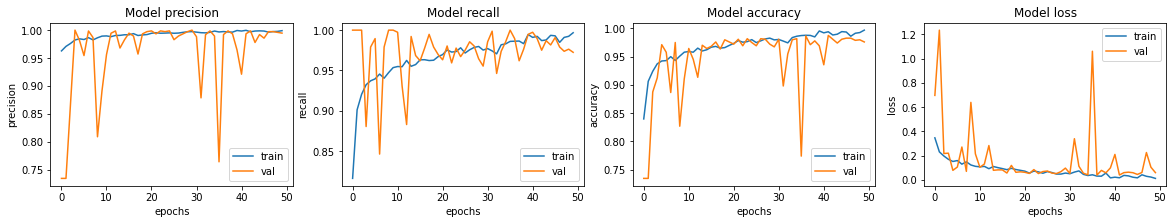

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 모델 평가(테스트)

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 113ms/step - loss: 1.8221 - accuracy: 0.8189 - precision: 0.7809 - recall: 0.9872
Loss: 1.8220608234405518,
Accuracy: 0.8189102411270142,
Precision: 0.7809330821037292,
Recall: 0.9871794581413269


## 회고하기

- 메인퀘스트 진행에 조퇴를 하게되어 다양한 실험을 하지 못했다.(에포크, 배치사이즈, 드롭아웃, 데이터 aug 여부에 따른 성능 평가)
- Resnet 구현 x
- 첫 실험의 모델(원래의 데이터 + 배치 16 + 에포크 50 + 드롭아웃 x)의 추론 결과에서 recall값이 다른 값에 비해 큰 것에 대한 분석이 필요하다.
- 위 세번째 내용에 대한 문제를 해결할 방법을 모델에 적용시켜 추가 실험 필요.
- 모델이 예측한 이미지를 시각화하여 직접 판단해보기 추가.

In [ ]:
#batch, epoch, aug, dropout 별 모델 성능 실험용 코드 블럭

BATCH_SIZE = 16
EPOCHS = 50

train_ds_og = prepare_for_training(train_ds, augment_ = False)
val_ds_og = prepare_for_training(val_ds, augment_ = False)
train_ds_ag = prepare_for_training(train_ds)
val_ds_ag = prepare_for_training(val_ds)

test_ds = test_ds_nb.batch(BATCH_SIZE)

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_og,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_og,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )